### Process Different Forecast Lengths to NetCDFs

Notebook contents 
* in `/hdd/snow_hydrology/hrrrak/` there are now a few folders which contain hrrr-ak downloads of different forecast lengths
* the goal is to clean up those datasets into netcdfs and then compare the timeseries at Powder Patch from them

created by Cassie Lumbrazo\
last updated: April 2025\
run location: UAS linux\
python environment: **xarray**, but now using **rasterio**

In [2]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
import seaborn as sns 
sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import scipy
import rioxarray
import rasterio 
import cfgrib

In [3]:
import os
import numpy as np
import xarray as xr
import cfgrib
from concurrent.futures import ProcessPoolExecutor

In [4]:
pwd

'/home/cassie/python/repos/juneau_data_analysis'

In [5]:
filepath = '/hdd/snow_hydrology/hrrrak/'

# now we have folder options, 
# f123, f567, f678, f6to11, f6to29 
# f123 will have a more simple data structure with variables, but then the following f567, etc. will all have a lot more variables downloaded 

# inside each of these are a subfolder, 
# WY2024, WY2025 

# for now, we should have some of WY2024 downloaded for everything 

In [6]:
# start by opening a single file with the new data structure so that we know how to handle all these variables
filepath = '/hdd/snow_hydrology/hrrrak/'
filename = 'f567/WY2024/hrrr.20231001/hrrr.t00z.wrfsfcf05.ak.grib2'

ds = cfgrib.open_datasets(filepath + filename)
# ds

In [7]:
len(ds)

45

okay, so instead of 3, we now have 45.\
that's fine, we just need to find the 3 we really want to work with and save them.

* 0 m surface, 2 m, and 10 m 
* then also clouds at the top of the atmosphere 

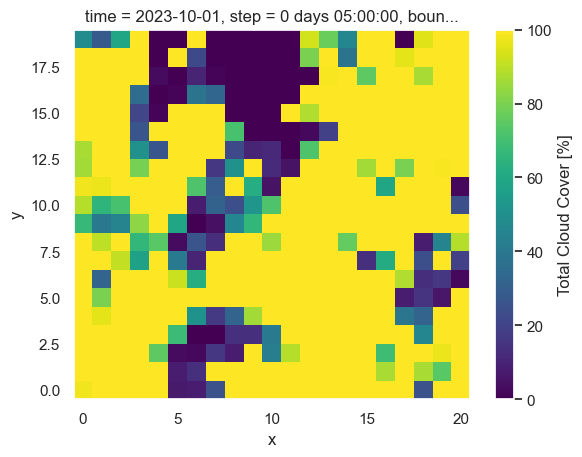

In [108]:
ds[4].tcc.plot()

I went through all 43, and found the following, 

In [ ]:
# Certainly useful, 
# ds[12] # Cord: heightAboveGround: 2, variables: pt, t2m, d2m, sh2, r2
# pt: potential temperature, t2m: 2 meter air temperature, d2m: 2 meter dew point temperature, sh2: 2 meter specific humidity, r2: 2 meter relative humidity

# ds[14] # Cord: heightAboveGround:10, variables: u10, v10, max_10si 
# max_10si: maximum 10 meter wind speed, u10: 10 meter u component of wind, v10: 10 meter v component of wind

# ds[43] # Cord: surface: 0, 41 variables: including t:temp, sde, prate, orog, sdswrf, sdlwrf

# ds[44] # Cord: surface: 0, variable: only sdwe: snow depth water equivalent

# ds[4]  # Cord: BoundaryLayerCloudLayer: 0, variable: tcc: total cloud cover %
# ds[33] # Cord: lowCloudLayer: 0, variable: lcc: low cloud cover %
# ds[22] # Cord: highCloudLayer:0, variable: hcc: high cloud cover %

# Maybe useful, 
# ds[29] # Cord: isothermZero: 0,   variables: pres, gh, r
# ds[8]  # Cord: depthBelowLand: 0, variable: mstav: moisture availibility 

Start by processing a single file with these specifications...

In [112]:
def process_grib_file(grib_path):
    """ Process a single .grib2 file and return an xarray dataset """
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        # Extract relevant subsets based on new known indices
        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        # Merge all relevant datasets
        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate 10m wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop variables if needed
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None


In [114]:
filepath = '/hdd/snow_hydrology/hrrrak/'
filename = 'f567/WY2024/hrrr.20231001/hrrr.t00z.wrfsfcf05.ak.grib2'
grib_path = filepath + filename
ds_test = process_grib_file(grib_path)
ds_test

<xarray.Dataset> Size: 94kB
Dimensions:                  (y: 20, x: 21)
Coordinates:
    time                     datetime64[ns] 8B 2023-10-01T05:00:00
    step                     timedelta64[ns] 8B 05:00:00
    latitude                 (y, x) float64 3kB 58.08 58.08 ... 58.59 58.59
    longitude                (y, x) float64 3kB 225.1 225.1 ... 226.0 226.1
    valid_time               datetime64[ns] 8B 2023-10-01T05:00:00
    boundaryLayerCloudLayer  float64 8B 0.0
Dimensions without coordinates: y, x
Data variables: (12/52)
    pt                       (y, x) float32 2kB ...
    temp                     (y, x) float32 2kB ...
    d2m                      (y, x) float32 2kB ...
    sh2                      (y, x) float32 2kB ...
    rh                       (y, x) float32 2kB ...
    u10                      (y, x) float32 2kB -4.91 -3.098 ... 1.152 1.152
    ...                       ...
    lai                      (y, x) float32 2kB ...
    vgtyp                    (y, x) float32 2kB ...
    cloud_total              (y, x) float32 2kB ...
    cloud_high               (y, x) float32 2kB ...
    cloud_low                (y, x) float32 2kB ...
    wind                     (y, x) float32 2kB 9.486 6.523 ... 1.693 1.158
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

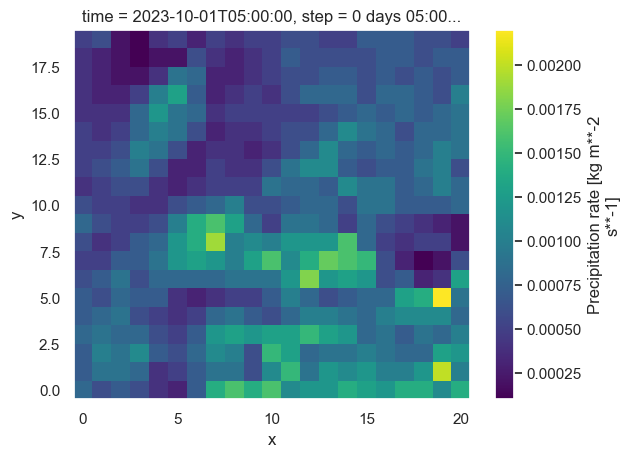

In [115]:
ds_test.precip_rate.plot()

Good, now let's do this for all the files inside the date_folder, like previous scripts...

In [ ]:
# Define main folder path
folderspath = '/hdd/snow_hydrology/hrrrak/f567/WY2024/'

# List all date folders
date_folders = sorted([f for f in os.listdir(folderspath) if f.startswith("hrrr.")])

def process_grib_file(grib_path):
    """Process a single .grib2 file and return an xarray dataset."""
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop unnecessary variables
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as the main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None

def process_date_folder(date_folder):
    """Process all GRIB2 files in a given date folder."""
    date_path = os.path.join(folderspath, date_folder)
    grib_files = sorted([
        os.path.join(date_path, f)
        for f in os.listdir(date_path) if f.endswith(".grib2")
    ])

    with ProcessPoolExecutor() as executor:
        ds_list = list(filter(None, executor.map(process_grib_file, grib_files)))

    if ds_list:
        try:
            return xr.concat(ds_list, dim="time")
        except ValueError as e:
            print(f"⚠️ Skipping {date_folder} due to concatenation error: {e}")
            return None
    return None

# Process all date folders in parallel
with ProcessPoolExecutor() as executor:
    all_ds_list = list(filter(None, executor.map(process_date_folder, date_folders)))

# Merge all datasets across all days
if all_ds_list:
    final_ds = xr.concat(all_ds_list, dim="time")
    print("✅ Successfully merged all datasets!")

    # Save to NetCDF
    output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f567_WY2024.nc"
    final_ds.to_netcdf(output_path)
    print(f"📁 Saved merged dataset to {output_path}")
else:
    print("⚠️ No valid datasets found.")


⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20231028/hrrr.t18z.wrfsfcf06.ak.grib2: list index out of range


Can't create file '/hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240522/hrrr.t21z.wrfsfcf06.ak.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 105, in from_file
    raise EOFError("End of file: %r" % file)
EOFError: End of file: <_io.BufferedReader name='/hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240522/hrrr.t21z.wrfsfcf06.ak.grib2'>

During handling of the above exception, anoth

⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240522/hrrr.t21z.wrfsfcf06.ak.grib2: No valid message found: '/hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240522/hrrr.t21z.wrfsfcf06.ak.grib2'
⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240513/hrrr.t15z.wrfsfcf06.ak.grib2: list index out of range
⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240523/hrrr.t00z.wrfsfcf07.ak.grib2: list index out of range
⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240523/hrrr.t21z.wrfsfcf06.ak.grib2: list index out of range
⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240523/hrrr.t09z.wrfsfcf06.ak.grib2: list index out of range
⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240523/hrrr.t09z.wrfsfcf05.ak.grib2: list index out of range
⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20240605/hrrr.t18z.wrfsfcf07.ak.grib2: list index out of range


Exception ignored in: Process ForkProcess-19:263:
Process ForkProcess-19:254:
Process ForkProcess-19:259:
Process ForkProcess-24:270:
Process ForkProcess-19:257:
Process ForkProcess-24:277:
Process ForkProcess-24:279:
Exception ignored in: Process ForkProcess-19:242:
Process ForkProcess-19:248:
Traceback (most recent call last):
Process ForkProcess-19:243:
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
Process ForkProcess-19:258:
Process ForkProcess-24:272:
Process ForkProcess-24:275:
Process ForkProcess-19:247:
Process ForkProcess-19:244:
Process ForkProcess-24:280:
Process ForkProcess-24:273:
Process ForkProcess-19:246:
Process ForkProcess-24:271:
Process ForkProcess-24:265:
Process ForkProcess-24:274:
Process ForkProcess-24:268:
Exception ignored in: Process ForkProcess-24:267:
Process ForkProcess-24:266:
Process ForkProcess-24:269:
Exception ignored in: Traceback (most recent c

Try to fix some of these issues... 

In [8]:
# ===== USER SETTINGS =====
folderspath = '/hdd/snow_hydrology/hrrrak/f567/WY2024/'
output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f567_WY2024_test1.nc"

start_date = datetime(2023, 10, 1)
end_date   = datetime(2024, 2, 15)

# ===== Filter folders by date range =====
all_folders = sorted([f for f in os.listdir(folderspath) if f.startswith("hrrr.")])
date_folders = [
    f for f in all_folders
    if start_date <= datetime.strptime(f.split(".")[1], "%Y%m%d") <= end_date
]

print(f"📅 Processing {len(date_folders)} folders from {start_date.date()} to {end_date.date()}")

def process_grib_file(grib_path):
    """Process a single .grib2 file and return an xarray dataset."""
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        # Make sure required indices exist
        required_indices = [12, 14, 43, 44, 4, 22, 33]
        if max(required_indices) >= len(ds_subsets):
            print(f"⚠️ Skipping {grib_path}: Not all expected datasets available.")
            return None

        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop unnecessary variables
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as the main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None

def process_date_folder(date_folder):
    """Process all GRIB2 files in a given date folder."""
    date_path = os.path.join(folderspath, date_folder)
    grib_files = sorted([
        os.path.join(date_path, f)
        for f in os.listdir(date_path) if f.endswith(".grib2")
    ])

    with ProcessPoolExecutor() as executor:
        ds_list = list(filter(None, executor.map(process_grib_file, grib_files)))

    if ds_list:
        try:
            return xr.concat(ds_list, dim="time")
        except ValueError as e:
            print(f"⚠️ Skipping {date_folder} due to concatenation error: {e}")
            return None
    return None

# ===== PROCESS ALL FOLDERS =====
with ProcessPoolExecutor() as executor:
    all_ds_list = list(filter(None, executor.map(process_date_folder, date_folders)))

# ===== CONCAT + SAVE =====
if all_ds_list:
    final_ds = xr.concat(all_ds_list, dim="time")
    print("✅ Successfully merged all datasets!")

    # Save to NetCDF
    # output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_WY2024.nc" # defined above
    final_ds.to_netcdf(output_path)
    print(f"📁 Saved merged dataset to {output_path}")
else:
    print("⚠️ No valid datasets found.")


📅 Processing 138 folders from 2023-10-01 to 2024-02-15
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f567/WY2024/hrrr.20231028/hrrr.t18z.wrfsfcf06.ak.grib2: Not all expected datasets available.
✅ Successfully merged all datasets!
📁 Saved merged dataset to /hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f567_WY2024_test1.nc


Now, let's do this for f678

In [9]:
# ===== USER SETTINGS =====
folderspath = '/hdd/snow_hydrology/hrrrak/f678/WY2024/'
output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f678_WY2024_test1.nc"

start_date = datetime(2023, 10, 1)
end_date   = datetime(2024, 2, 15)

# ===== Filter folders by date range =====
all_folders = sorted([f for f in os.listdir(folderspath) if f.startswith("hrrr.")])
date_folders = [
    f for f in all_folders
    if start_date <= datetime.strptime(f.split(".")[1], "%Y%m%d") <= end_date
]

print(f"📅 Processing {len(date_folders)} folders from {start_date.date()} to {end_date.date()}")

def process_grib_file(grib_path):
    """Process a single .grib2 file and return an xarray dataset."""
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        # Make sure required indices exist
        required_indices = [12, 14, 43, 44, 4, 22, 33]
        if max(required_indices) >= len(ds_subsets):
            print(f"⚠️ Skipping {grib_path}: Not all expected datasets available.")
            return None

        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop unnecessary variables
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as the main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None

def process_date_folder(date_folder):
    """Process all GRIB2 files in a given date folder."""
    date_path = os.path.join(folderspath, date_folder)
    grib_files = sorted([
        os.path.join(date_path, f)
        for f in os.listdir(date_path) if f.endswith(".grib2")
    ])

    with ProcessPoolExecutor() as executor:
        ds_list = list(filter(None, executor.map(process_grib_file, grib_files)))

    if ds_list:
        try:
            return xr.concat(ds_list, dim="time")
        except ValueError as e:
            print(f"⚠️ Skipping {date_folder} due to concatenation error: {e}")
            return None
    return None

# ===== PROCESS ALL FOLDERS =====
with ProcessPoolExecutor() as executor:
    all_ds_list = list(filter(None, executor.map(process_date_folder, date_folders)))

# ===== CONCAT + SAVE =====
if all_ds_list:
    final_ds = xr.concat(all_ds_list, dim="time")
    print("✅ Successfully merged all datasets!")

    # Save to NetCDF
    # output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_WY2024.nc" # defined above
    final_ds.to_netcdf(output_path)
    print(f"📁 Saved merged dataset to {output_path}")
else:
    print("⚠️ No valid datasets found.")


📅 Processing 138 folders from 2023-10-01 to 2024-02-15
✅ Successfully merged all datasets!
📁 Saved merged dataset to /hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f678_WY2024_test1.nc


And, for f6to11

In [10]:
# ===== USER SETTINGS =====
folderspath = '/hdd/snow_hydrology/hrrrak/f6to11/WY2024/'
output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f6to11_WY2024_test1.nc"

start_date = datetime(2023, 10, 1)
end_date   = datetime(2024, 2, 15)

# ===== Filter folders by date range =====
all_folders = sorted([f for f in os.listdir(folderspath) if f.startswith("hrrr.")])
date_folders = [
    f for f in all_folders
    if start_date <= datetime.strptime(f.split(".")[1], "%Y%m%d") <= end_date
]

print(f"📅 Processing {len(date_folders)} folders from {start_date.date()} to {end_date.date()}")

def process_grib_file(grib_path):
    """Process a single .grib2 file and return an xarray dataset."""
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        # Make sure required indices exist
        required_indices = [12, 14, 43, 44, 4, 22, 33]
        if max(required_indices) >= len(ds_subsets):
            print(f"⚠️ Skipping {grib_path}: Not all expected datasets available.")
            return None

        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop unnecessary variables
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as the main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None

def process_date_folder(date_folder):
    """Process all GRIB2 files in a given date folder."""
    date_path = os.path.join(folderspath, date_folder)
    grib_files = sorted([
        os.path.join(date_path, f)
        for f in os.listdir(date_path) if f.endswith(".grib2")
    ])

    with ProcessPoolExecutor() as executor:
        ds_list = list(filter(None, executor.map(process_grib_file, grib_files)))

    if ds_list:
        try:
            return xr.concat(ds_list, dim="time")
        except ValueError as e:
            print(f"⚠️ Skipping {date_folder} due to concatenation error: {e}")
            return None
    return None

# ===== PROCESS ALL FOLDERS =====
with ProcessPoolExecutor() as executor:
    all_ds_list = list(filter(None, executor.map(process_date_folder, date_folders)))

# ===== CONCAT + SAVE =====
if all_ds_list:
    final_ds = xr.concat(all_ds_list, dim="time")
    print("✅ Successfully merged all datasets!")

    # Save to NetCDF
    final_ds.to_netcdf(output_path)
    print(f"📁 Saved merged dataset to {output_path}")
else:
    print("⚠️ No valid datasets found.")


📅 Processing 138 folders from 2023-10-01 to 2024-02-15
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f6to11/WY2024/hrrr.20231002/hrrr.t00z.wrfsfcf07.ak.grib2: Not all expected datasets available.
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f6to11/WY2024/hrrr.20231026/hrrr.t06z.wrfsfcf10.ak.grib2: Not all expected datasets available.
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f6to11/WY2024/hrrr.20240117/hrrr.t12z.wrfsfcf09.ak.grib2: Not all expected datasets available.
✅ Successfully merged all datasets!
📁 Saved merged dataset to /hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f6to11_WY2024_test1.nc


And finally, for f6to29

In [11]:
# ===== USER SETTINGS =====
folderspath = '/hdd/snow_hydrology/hrrrak/f6to29/WY2024/'
output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f6to29_WY2024_test1.nc"

start_date = datetime(2023, 10, 1)
end_date   = datetime(2024, 2, 15)

# ===== Filter folders by date range =====
all_folders = sorted([f for f in os.listdir(folderspath) if f.startswith("hrrr.")])
date_folders = [
    f for f in all_folders
    if start_date <= datetime.strptime(f.split(".")[1], "%Y%m%d") <= end_date
]

print(f"📅 Processing {len(date_folders)} folders from {start_date.date()} to {end_date.date()}")

def process_grib_file(grib_path):
    """Process a single .grib2 file and return an xarray dataset."""
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        # Make sure required indices exist
        required_indices = [12, 14, 43, 44, 4, 22, 33]
        if max(required_indices) >= len(ds_subsets):
            print(f"⚠️ Skipping {grib_path}: Not all expected datasets available.")
            return None

        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop unnecessary variables
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as the main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None

def process_date_folder(date_folder):
    """Process all GRIB2 files in a given date folder."""
    date_path = os.path.join(folderspath, date_folder)
    grib_files = sorted([
        os.path.join(date_path, f)
        for f in os.listdir(date_path) if f.endswith(".grib2")
    ])

    with ProcessPoolExecutor() as executor:
        ds_list = list(filter(None, executor.map(process_grib_file, grib_files)))

    if ds_list:
        try:
            return xr.concat(ds_list, dim="time")
        except ValueError as e:
            print(f"⚠️ Skipping {date_folder} due to concatenation error: {e}")
            return None
    return None

# ===== PROCESS ALL FOLDERS =====
with ProcessPoolExecutor() as executor:
    all_ds_list = list(filter(None, executor.map(process_date_folder, date_folders)))

# ===== CONCAT + SAVE =====
if all_ds_list:
    final_ds = xr.concat(all_ds_list, dim="time")
    print("✅ Successfully merged all datasets!")

    # Save to NetCDF
    final_ds.to_netcdf(output_path)
    print(f"📁 Saved merged dataset to {output_path}")
else:
    print("⚠️ No valid datasets found.")


📅 Processing 138 folders from 2023-10-01 to 2024-02-15
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f6to29/WY2024/hrrr.20231028/hrrr.t00z.wrfsfcf22.ak.grib2: Not all expected datasets available.
✅ Successfully merged all datasets!
📁 Saved merged dataset to /hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f6to29_WY2024_test1.nc


In [8]:
# ===== USER SETTINGS =====
folderspath = '/hdd/snow_hydrology/hrrrak/f567/WY2025/'
output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f567_WY2025_test1.nc"

start_date = datetime(2024, 10, 1)
end_date   = datetime(2025, 4, 15)

# ===== Filter folders by date range =====
all_folders = sorted([f for f in os.listdir(folderspath) if f.startswith("hrrr.")])
date_folders = [
    f for f in all_folders
    if start_date <= datetime.strptime(f.split(".")[1], "%Y%m%d") <= end_date
]

print(f"📅 Processing {len(date_folders)} folders from {start_date.date()} to {end_date.date()}")

def process_grib_file(grib_path):
    """Process a single .grib2 file and return an xarray dataset."""
    try:
        ds_subsets = cfgrib.open_datasets(grib_path)

        # Make sure required indices exist
        required_indices = [12, 14, 43, 44, 4, 22, 33]
        if max(required_indices) >= len(ds_subsets):
            print(f"⚠️ Skipping {grib_path}: Not all expected datasets available.")
            return None

        ds_2m = ds_subsets[12].drop_vars('heightAboveGround', errors='ignore')
        ds_10m = ds_subsets[14].drop_vars('heightAboveGround', errors='ignore')
        ds_surface1 = ds_subsets[43].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_surface2 = ds_subsets[44].assign_coords({'heightAboveGround': 0.0}).drop_vars('heightAboveGround', errors='ignore')
        ds_clouds = xr.merge([
            ds_subsets[4].drop_vars('BoundaryLayerCloudLayer', errors='ignore'),
            ds_subsets[22].drop_vars('highCloudLayer', errors='ignore'),
            ds_subsets[33].drop_vars('lowCloudLayer', errors='ignore')
        ])

        ds_merged = xr.merge([ds_2m, ds_10m, ds_surface1, ds_surface2, ds_clouds], compat='override')

        # Calculate wind speed
        ds_merged['wind'] = np.sqrt(ds_merged['u10']**2 + ds_merged['v10']**2)
        ds_merged['wind'].attrs.update({
            'long_name': '10 metre wind speed calculated from u and v wind components',
            'GRIB_shortName': '10m wind',
            'standard_name': 'wind speed',
            'GRIB_name': '10 metre wind speed',
            'GRIB_cfName': 'wind_speed',
            'GRIB_cfVarName': 'wind10'
        })

        # Rename variables
        ds_merged = ds_merged.rename({
            't': 'temp_surface',
            't2m': 'temp',
            'r2': 'rh',
            'sdwe': 'swe',
            'sde': 'snowdepth',
            'sdswrf': 'swrad',
            'sdlwrf': 'lwrad',
            'prate': 'precip_rate',
            'tcc': 'cloud_total',
            'lcc': 'cloud_low',
            'hcc': 'cloud_high'
        })

        # Drop unnecessary variables
        drop_vars = [var for var in ['unknown', 'surface'] if var in ds_merged]
        ds_merged = ds_merged.drop_vars(drop_vars, errors='ignore')

        # Set valid_time as the main time coordinate
        ds_merged = ds_merged.assign_coords({'time': ds_merged.valid_time})

        return ds_merged

    except Exception as e:
        print(f"⚠️ Error processing {grib_path}: {e}")
        return None

def process_date_folder(date_folder):
    """Process all GRIB2 files in a given date folder."""
    date_path = os.path.join(folderspath, date_folder)
    grib_files = sorted([
        os.path.join(date_path, f)
        for f in os.listdir(date_path) if f.endswith(".grib2")
    ])

    with ProcessPoolExecutor() as executor:
        ds_list = list(filter(None, executor.map(process_grib_file, grib_files)))

    if ds_list:
        try:
            return xr.concat(ds_list, dim="time")
        except ValueError as e:
            print(f"⚠️ Skipping {date_folder} due to concatenation error: {e}")
            return None
    return None

# ===== PROCESS ALL FOLDERS =====
with ProcessPoolExecutor() as executor:
    all_ds_list = list(filter(None, executor.map(process_date_folder, date_folders)))

# ===== CONCAT + SAVE =====
if all_ds_list:
    final_ds = xr.concat(all_ds_list, dim="time")
    print("✅ Successfully merged all datasets!")

    # Save to NetCDF
    # output_path = "/hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_WY2024.nc" # defined above
    final_ds.to_netcdf(output_path)
    print(f"📁 Saved merged dataset to {output_path}")
else:
    print("⚠️ No valid datasets found.")


📅 Processing 197 folders from 2024-10-01 to 2025-04-15


skipping corrupted Message
Traceback (most recent call last):
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 97, in from_file
    codes_id = eccodes.codes_grib_new_from_file(file)
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/gribapi/gribapi.py", line 409, in grib_new_from_file
    GRIB_CHECK(err)
    ~~~~~~~~~~^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-pack

⚠️ Skipping /hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20241024/hrrr.t12z.wrfsfcf07.ak.grib2: Not all expected datasets available.


skipping corrupted Message
Traceback (most recent call last):
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 97, in from_file
    codes_id = eccodes.codes_grib_new_from_file(file)
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/gribapi/gribapi.py", line 409, in grib_new_from_file
    GRIB_CHECK(err)
    ~~~~~~~~~~^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-pack

⚠️ Skipping /hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20241024/hrrr.t12z.wrfsfcf05.ak.grib2: Not all expected datasets available.


skipping corrupted Message
Traceback (most recent call last):
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 97, in from_file
    codes_id = eccodes.codes_grib_new_from_file(file)
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/gribapi/gribapi.py", line 409, in grib_new_from_file
    GRIB_CHECK(err)
    ~~~~~~~~~~^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-pack

⚠️ Skipping /hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20241024/hrrr.t12z.wrfsfcf06.ak.grib2: Not all expected datasets available.
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20241024/hrrr.t09z.wrfsfcf07.ak.grib2: Not all expected datasets available.
⚠️ Skipping /hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20241024/hrrr.t06z.wrfsfcf05.ak.grib2: Not all expected datasets available.


Can't create file '/hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20250301/hrrr.t00z.wrfsfcf05.ak.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cassie/programs/miniforge3/envs/rasterio/lib/python3.13/site-packages/cfgrib/messages.py", line 105, in from_file
    raise EOFError("End of file: %r" % file)
EOFError: End of file: <_io.BufferedReader name='/hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20250301/hrrr.t00z.wrfsfcf05.ak.grib2'>

During handling of the above exception, anoth

⚠️ Error processing /hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20250301/hrrr.t00z.wrfsfcf05.ak.grib2: No valid message found: '/hdd/snow_hydrology/hrrrak/f567/WY2025/hrrr.20250301/hrrr.t00z.wrfsfcf05.ak.grib2'
✅ Successfully merged all datasets!
📁 Saved merged dataset to /hdd/snow_hydrology/hrrrak/netcdf/hrrrak_merged_grib_f567_WY2025_test1.nc


So this is all very imperfect, because some files are being skipped and maybe the datasets have different structures... 

I do not think it's worth more effort right now to fix all of this since it's just exploratative to see just *how* different the forecasts are... 

For now, we will move to a new notebook to load the netcdfs and go from there to compare timeseries at Powder Patch.

## Ideas to improve this workflow once I have time, 
* if the forecast/datafile doesn't load, then fill everything with nan or something to keep all the timeseries/datetimes the same lengths..
* check the data structure of the datasets, I really only looked at a single grib2 files to create that code
* ADD THE CRS fix inside this code so that the loaded netcdf has the correct CRS!!!!!!!!!
* MISSING TP: TOTAL PRECIP in the script...